# DSCI 100 Final Project - Heart Disease Classification

DSCI 100 002 Group 10

Group Members: Lily Xie, Eric Ai, William Wang

# Temporary Housekeeping Checklist (To be Removed at the end)



### Feedback and comment on the project proposal
* Lack of explanations of summary table and graphs. What do you hope readers will gleam from looking at your graphs? Providing commentary on tables/graphs would be a great way of supporting your use of predictors.


### General checklist
1. Include reference and explaination in why we choose the three predictors ("You should have some sort of further evidence to back this up. This should be done with either outside sources or your visualizations.")




* Don't forget to check code format after we finish everything (eg. space, pipe operator, etc.)
* make sure we clean it at the end and only include relevant information and graphs!
* can also add a reference for the discussion - impact part. eg. previous examples of using medical analysis to prevent heart diseases.



## Group Project Requirements (TBD)

just for an easy reference
https://canvas.ubc.ca/courses/83542/assignments/1106464

# Introduction

Heart disease is consistently rated as the top 1 cause of death around the world over the last two decades. A lot of factors may or may not have an effect on the presence of heart disease, and our group is interested in exploring the possible factors of heart disease via relevant dataset(s). In the data analysis we are about to perform, we plan to select some of the possible correlated factors to heart disease according to possible relevance, and assess how well the chosen predictors can predict heart disease using knn-classification.

Before we begin, we would like to briefly explain the dataset we chose. The data set we plan to use is processed.cleveland.data; it is collected from individuals residing in Cleveland, USA. In this dataset, heart disease is shown as the percentage narrowing of blood vessels. A value of 0 indicates < 50% diameter narrowing and no presence of heart disease, and a value >=1 indicate> 50% diameter narrowing as well as the presence of heart disease.

Our dataset also contains the following 13 variables as potential predictors: age, sex, types of chest pain (cp), resting blood pressure (trestbps), cholesterol level (chol), fasting blood sugar (fbs), resting electrocardiographic measurement (restecg), max heart rate (thalach), trigger (exang, exercise=1, other= 0), exercise-induced depression (oldpeak), the slope of the peak exercise ST segment (slope), number of vessels colored by fluoroscopy (ca, ranges from 0-3), thal (3 = normal; 6 = fixed defect; 7 = reversible defect). All of the above factors may or may not affect the chance of having heart disease.

During the method section, we determine our predictors, age and thalach, using density graphs created from our dataset(figure 1.1), the explanation and reasoning are under Methods & Results.

Therefore, our scientific question for this study is: 

<b> Which is/are the best predictor(s) for heart disease prediction , and what is the accuracy of the classifier based on the chosen predictors?<b> 

To answer this question, we will be performing data analysis in the heart disease dataset as shown below. 


 


# Methods & Results

In [62]:
options(repr.matrix.max.rows = 20)
library(repr)
library(tidyverse)
library(tidymodels)
library(dplyr) 
library(gridExtra)
options(repr.matrix.max.rows = 8)

set.seed(2022)

As we download the file processed_cleveland.data and opened it in a text editor, we can see that all the variables for observations are separated by commas. We can go ahead and read in the dataset from the website using read_csv, and assign it to an object called cleveland_data_raw.


We call cleveland_data_raw to see what the dataset looks like.

In [63]:
set.seed(2022)
cleveland_data_raw <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data", col_names = FALSE)
cleveland_data_raw

Parsed with column specification:
cols(
  X1 = col_double(),
  X2 = col_double(),
  X3 = col_double(),
  X4 = col_double(),
  X5 = col_double(),
  X6 = col_double(),
  X7 = col_double(),
  X8 = col_double(),
  X9 = col_double(),
  X10 = col_double(),
  X11 = col_double(),
  X12 = col_character(),
  X13 = col_character(),
  X14 = col_double()
)



X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
68,1,4,144,193,1,0,141,0,3.4,2,2.0,7.0,2
57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0,3
57,0,2,130,236,0,2,174,0,0.0,2,1.0,3.0,1
38,1,3,138,175,0,0,173,0,0.0,1,?,3.0,0


As shown on the table, the data set follows the criterion for tidy data: each variable forms a column, each observation forms a row, and each cell is a single measurement. The only element missing is the column titles, and we can manually assign them according to the data description on the web.


In [64]:
set.seed(2022)
cleveland_data = cleveland_data_raw %>%
                 rename (age = X1, sex = X2, cp= X3, trestbps = X4, 
                         chol = X5, fbs = X6, restecg = X7, thalach = X8,
                         exang = X9, oldpeak = X10, slope = X11, ca = X12,
                         thal = X13, num = X14)
cleveland_data

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
68,1,4,144,193,1,0,141,0,3.4,2,2.0,7.0,2
57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0,3
57,0,2,130,236,0,2,174,0,0.0,2,1.0,3.0,1
38,1,3,138,175,0,0,173,0,0.0,1,?,3.0,0


Table1.1 Cleveland Heart Disease Data Frame with Coresponding Column Names

Here are what all the column names represent:

<blockquote>

1. age: age in years
    
2. sex: sex (1 = male; 0 = female)
    
3. cp: chest pain type
       -- Value 1: typical angina
       -- Value 2: atypical angina
       -- Value 3: non-anginal pain
       -- Value 4: asymptomatic
    
4. trestbps: resting blood pressure (in mm Hg on admission to the hospital)
    
5. chol: serum cholestoral in mg/dl
    
6. fbs: fasting blood sugar > 120 mg/dl, (1 = true; 0 = false)
    
7. restecg: resting electrocardiographic results
       -- Value 0: normal
       -- Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
       -- Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria
    
8. thalach: maximum heart rate achieved
    
9. exang: exercise induced angina (1 = yes; 0 = no)
    
10. oldpeak: ST depression induced by exercise relative to rest
    
11. slope: the slope of the peak exercise ST segment
       -- Value 1: upsloping
       -- Value 2: flat
       -- Value 3: downsloping
    
12. ca: number of major vessels (0-3) colored by flourosopy
    
13. thal: 3 = normal; 6 = fixed defect; 7 = reversable defect
    
14. num: diagnosis of heart disease (angiographic disease status)
       -- Value 0: < 50% diameter narrowing
       -- Value 1: > 50% diameter narrowing

Note that "num" is also the predicted attribute in our data analysis.

To better perform the data analysis, we need to wrangle the data a bit more. As mentioned in the description of the data set, there are only 2 distinct levels in blood vessel narrowing levels:  Value 0 indicates < 50% diameter narrowing, and Value 1 indicates > 50% diameter narrowing. Since we are only interested in the presence/absence of heart disease, we converted num values >=1 all into 1 and values of 0 all into 0, so that there are only two classes: 0 = no heart disease, 1 = have heart disease. 

We also converted the variable “num” (which is what we are trying to predict) into a factor, so that it can be used in our knn-classification algorithm. 

In [65]:
set.seed(2022)
# Cleaning and wrangling
cleveland_data_clean <- cleveland_data %>% 
# Turning 1 2 3 4 in num into 1, keep 0 as 0
                       mutate(num = ifelse(num >= 1, 1, 0),

# Changing num into a factor for later analysis
                              num = as_factor(num)) %>% 

# Removing row with missing value 
                       filter_all(all_vars(!(. %in% c('?'))))



cleveland_data_clean

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,1
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
45,1,1,110,264,0,0,132,0,1.2,2,0.0,7.0,1
68,1,4,144,193,1,0,141,0,3.4,2,2.0,7.0,1
57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0,1
57,0,2,130,236,0,2,174,0,0.0,2,1.0,3.0,1


table1.2 Cleveland data after cleaning  <blockquote>Quick Note: In column "num", 1 indicates with heart disease, 0 is without heart disease.</blockquote> 

### Splitting for Training and Testing Sets


Before we perform any further steps, we need to split the dataset into training set and testing set. This is necessary because we cannot train or work on the testing dataset. If we do, the accuracy of our classifier will be falsely high. Thus, we split the dataset into 75% training set and 25% testing set. We set the variable to predict to num (0 = no heart disease, 1 = heart with disease).


The reason for this 75% split is because there are not many rows in our dataset – 223 observations in total. Thus, we need to get enough data to train our classifier, in this case no less than 75% seems reasonable.

In [66]:
set.seed(2022)
#Splitting the dataset into training and testing sets
cleveland_split <- initial_split(cleveland_data_clean, prop = 0.75, strata = num)  
cleveland_training <- training(cleveland_split)
cleveland_testing <- testing(cleveland_split)

## Choosing Predictors

Then we begin the process of choosing predictors. We first eliminate all the categorical variables since what we learned in classification mainly focused on using numeric predictors. Moreover, if we directly convert the categorical variables into numerical ones, the distance between the numeric values converted would negatively impact the accuracy. This can be explained using an example: 
<blockquote>
Ex. cp(chest pain type) in our data set has four different categories. However, the four chest pain categories do not have a rank in strength–they are equally different. Therefore, if we convert them to 1,2,3 and 4 respectively, then 1 would be further away from 3 compared with 2 to 3, while the categories of 1 and 2 are equally different from category 3 in reality.   


Thus, the act of converting categorical variables into numerical variables would negatively affect the accuracy of the classifier. Therefore, we deselect all the categorical variables: sex, cp, fbs, restecg, exang, slope, ca, thal. 


### Training Data Predictor Data Plot

We then plot density graphs (Figure 1.1) for all the numerical variables to see which ones are the best predictors. The pink areas represent no heart disease, and the blue areas are with heart disease. To do that, we measure if there is a difference for each variable with and without heart disease. The reasoning is that the more difference there is, the stronger the relationship between the predictors and the presence of heart disease, and the more accurate our classifier will be. 

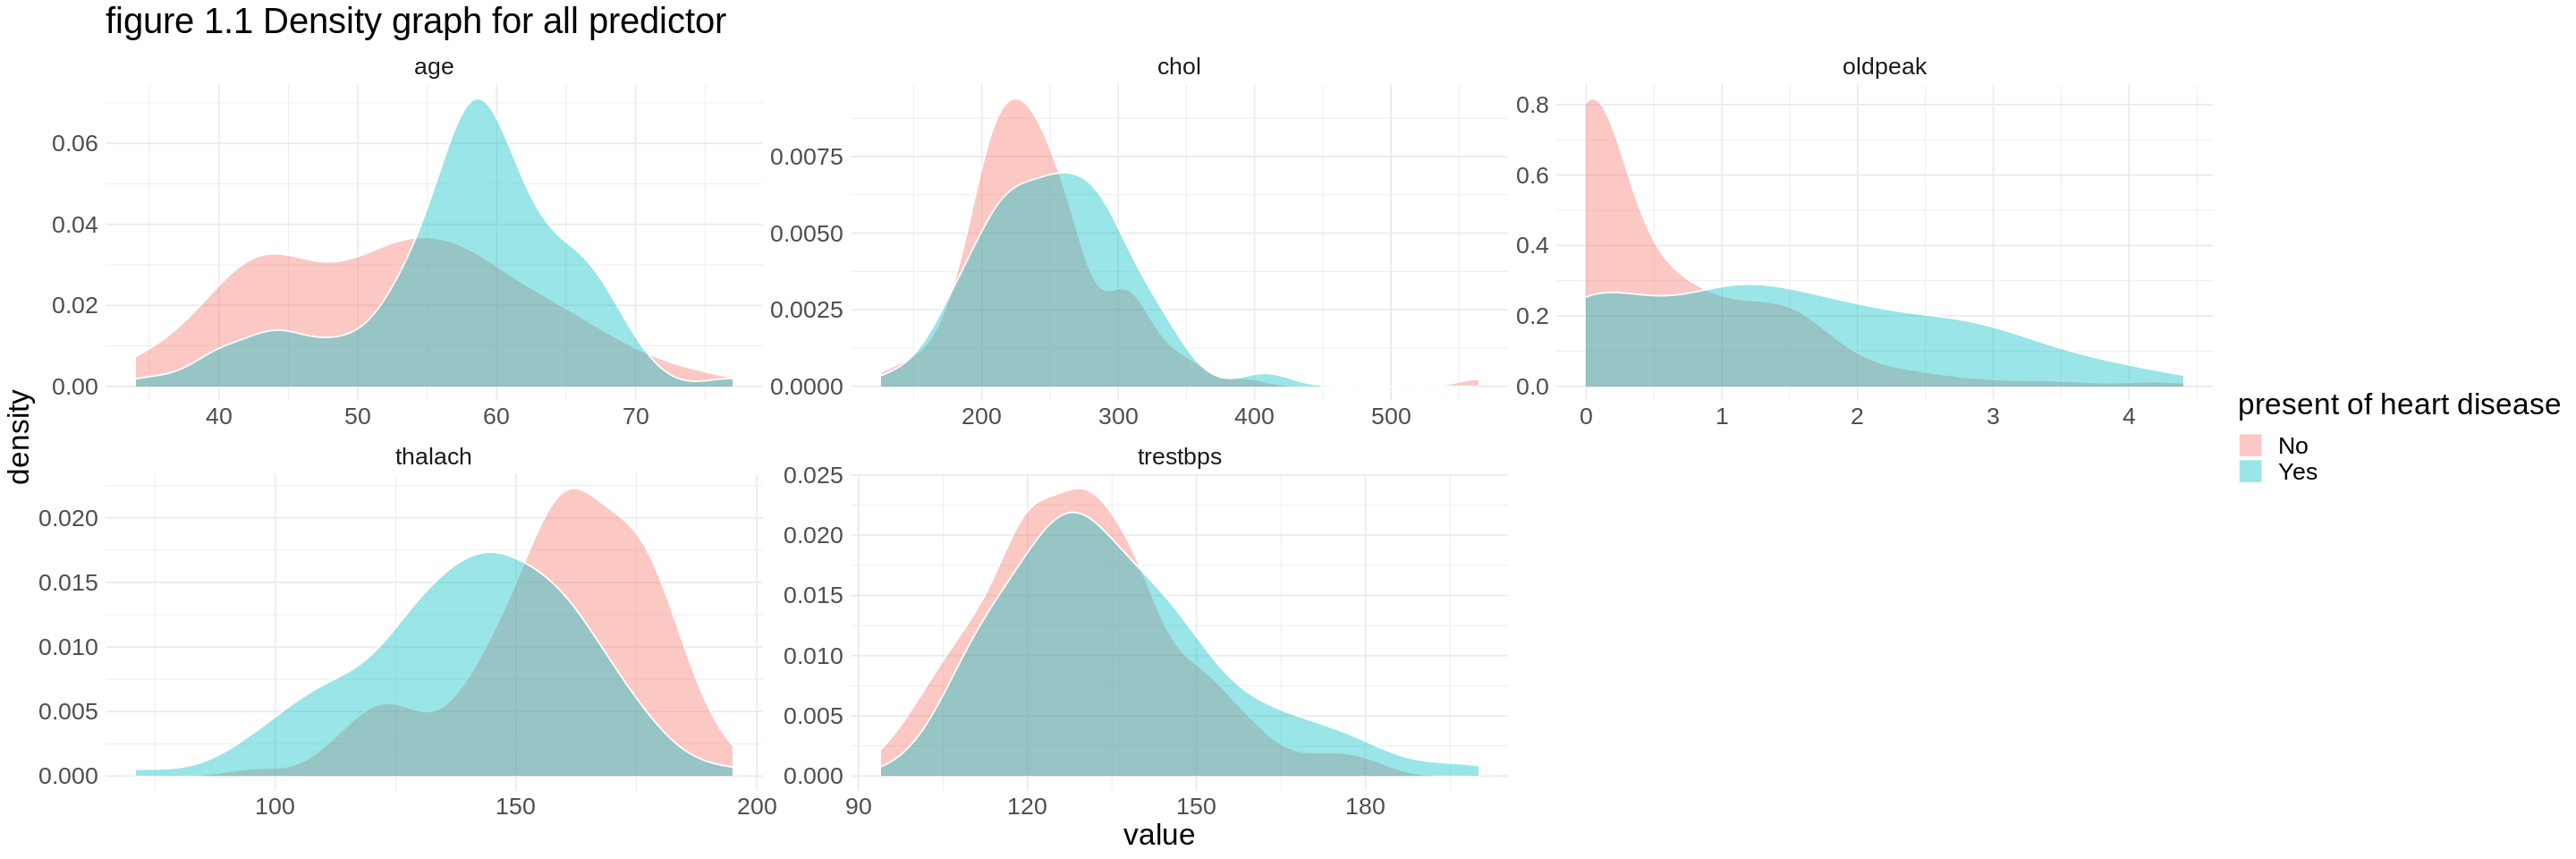

In [67]:
set.seed(2022)
options(repr.plot.height = 8, repr.plot.width = 24)

cleveland_numeric <- cleveland_training %>% 
                     select(-sex, -cp , -fbs, -restecg, -exang, -slope, -ca, -thal) 

cleveland_numeric %>%
          pivot_longer(cols = - num, names_to = 'category', values_to = 'value')  %>% 
          ggplot(aes(value, fill = num)) +
          geom_density(alpha = 0.4, colour = 'white') +
          facet_wrap(~ category, scales = 'free') +
          theme_minimal() +
          theme(text = element_text(size = 20))+
          scale_fill_discrete(name='present of heart disease',labels=c("No", "Yes"))+
          ggtitle("figure 1.1 Density graph for all predictor ")

We can estimate the difference by roughly dividing the non-overlapped area by the overlapped area. The bigger the ratio, the more the difference. From the above estimation, we conclude that age , thalach (maximum heart rate) and oldpeak(ST depression while exercising) express the most difference due to their larger ratio of un-overlapped / overlapped area. 

<blockquote>
For oldpeak, although the ratio of non-overlapped / overlapped is alsmot as large, it’s extremely hard to test, since the diagnosis of depression invloves many complicated steps, let alone exercise induced depression. Due to the inaccessibility of the testing of oldpeak, we decided to use age , thahach ,and oldpeak as our predictors; we will use age and thalach to train and test our data. Note that thalach means the maximum heart rate achieved.


### Training Data Visualization

After choosing our exploratory variables, we present a visualization of age and thalach in the training dataset by using histograms. As shown below, each predictor has 2 plots, one shows the predictor distribution for people who do not have heart disease (figure 2.1, figure 2.2), and one shows the distribution of those who have heart disease (figure 2.3, figure 2.4). We can compare the different population distributions between with and without vertically.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
“Removed 2 rows containing missing values (geom_bar).”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
“Removed 2 rows containing missing values (geom_bar).”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
“Removed 2 rows containing missing values (geom_bar).”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
“Removed 2 rows containing missing values (geom_bar).”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



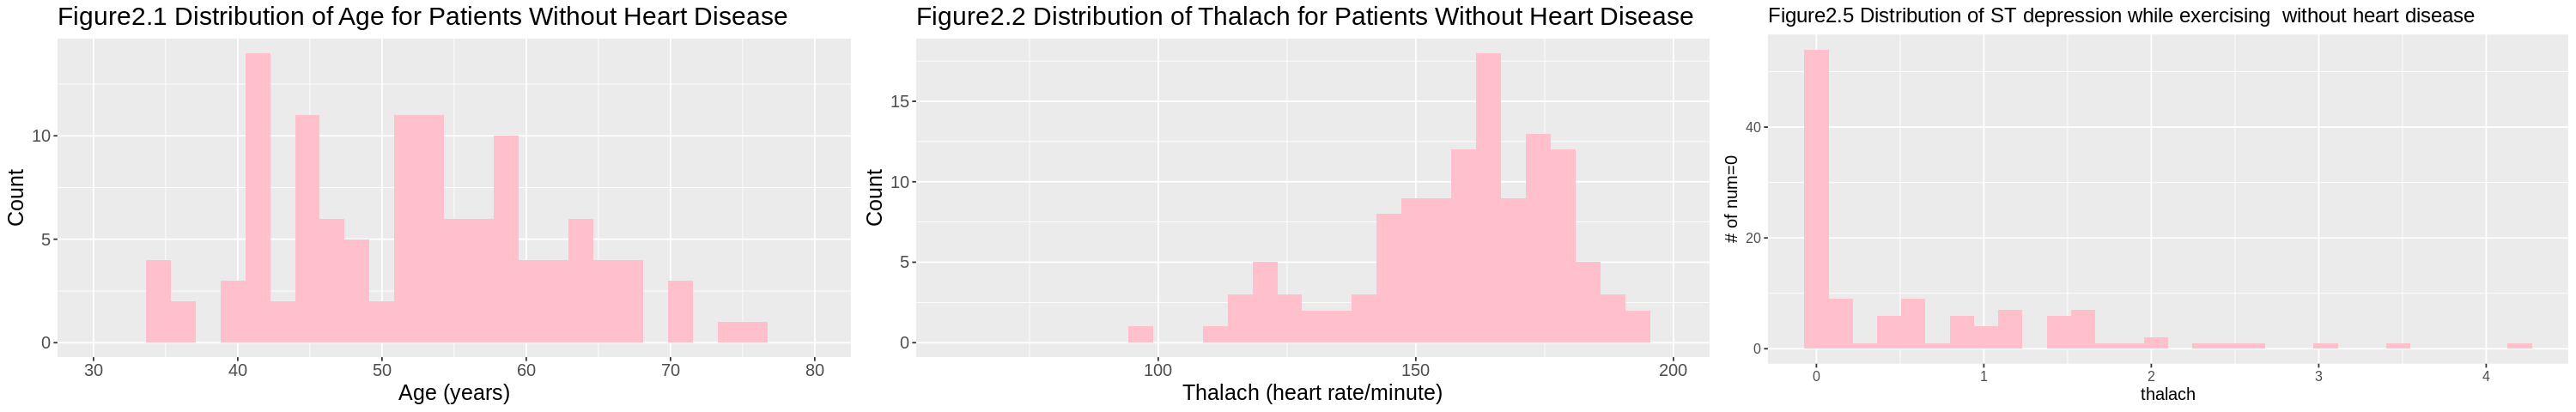

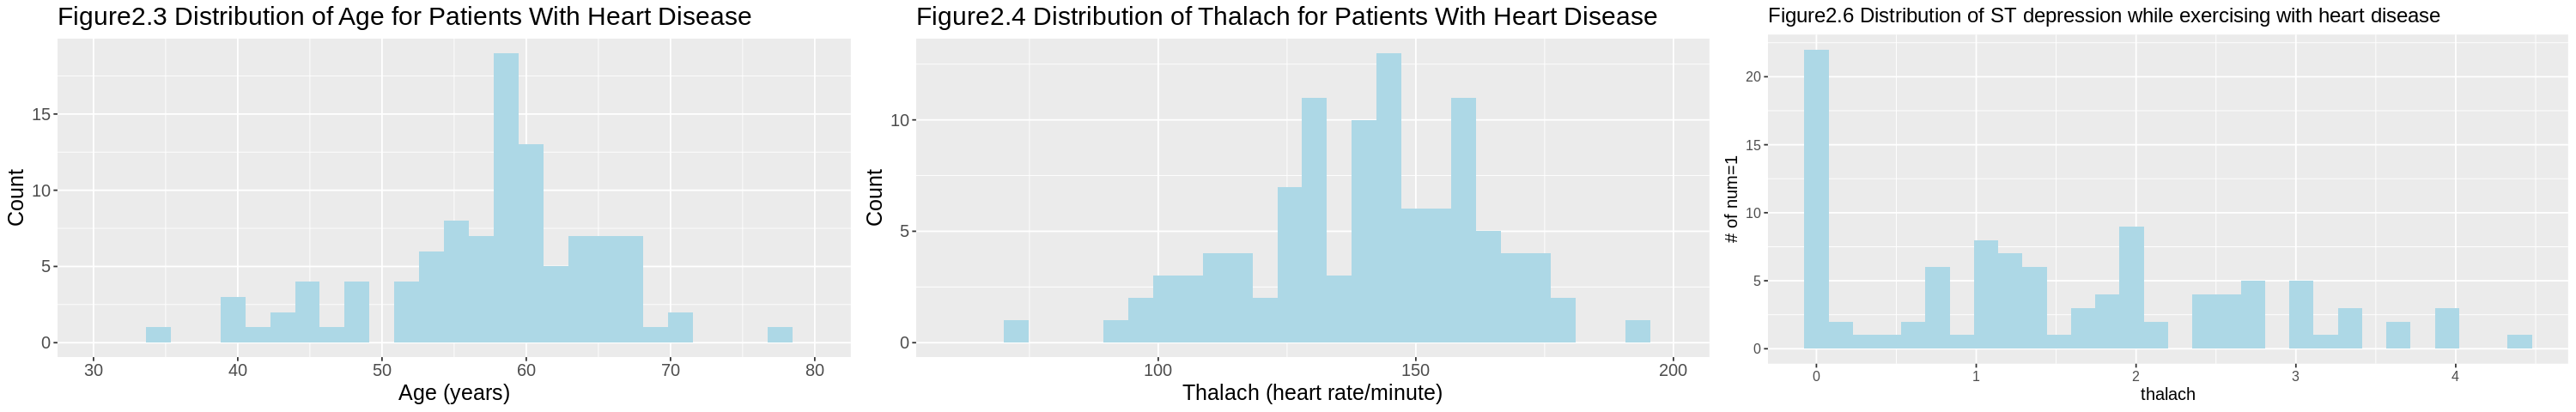

In [75]:
options(repr.plot.height = 4, repr.plot.width = 25)

plot_age_0 <- cleveland_training %>%
              filter(num == 0) %>%
              ggplot(aes(x = age)) + 
              geom_histogram(fill = "pink") +
              labs(x = "Age (years)", y= "Count") +
              theme(text = element_text(size = 15)) +
              ggtitle("Figure2.1 Distribution of Age for Patients Without Heart Disease") +
              xlim(c(30, 80))

plot_age_1 <- cleveland_training %>%
              filter(num == 1) %>%
              ggplot(aes(x = age)) + 
              geom_histogram(fill = "light blue") +
              labs(x = "Age (years)", y= "Count") +
              theme(text = element_text(size = 15)) +
              ggtitle("Figure2.3 Distribution of Age for Patients With Heart Disease") +
              xlim(c(30, 80))

plot_thalach_0 <- cleveland_training %>%
              filter(num == 0) %>%
              ggplot(aes(x = thalach)) + 
              geom_histogram(fill = "pink") +
              labs(x = "Thalach (heart rate/minute)", y= "Count") +
              theme(text = element_text(size = 15)) +
              ggtitle("Figure2.2 Distribution of Thalach for Patients Without Heart Disease") +
              xlim(c(60, 200))

plot_thalach_1 <- cleveland_training %>%
              filter(num == 1) %>%
              ggplot(aes(x = thalach)) + 
              geom_histogram(fill = "light blue") +
              labs(x = "Thalach (heart rate/minute)", y= "Count") +
              theme(text = element_text(size = 15)) +
              ggtitle("Figure2.4 Distribution of Thalach for Patients With Heart Disease") +
              xlim(c(60, 200))


plot_oldpeak_0<-cleveland_training%>%
filter(num==0)%>%
ggplot(aes(x = oldpeak)) + 
   geom_histogram(fill= "pink") +
    labs(x= "thalach", y= "# of num=0")+
    theme(text = element_text(size=12))+
    ggtitle("Figure2.5 Distribution of ST depression while exercising  without heart disease")


plot_oldpeak_1<-cleveland_training%>%
filter(num==1)%>%
ggplot(aes(x = oldpeak)) + 
   geom_histogram(fill = "light blue") +
    labs(x= "thalach", y= "# of num=1")+
    theme(text = element_text(size=12))+
    ggtitle("Figure2.6 Distribution of ST depression while exercising with heart disease")


grid.arrange(plot_age_0, plot_thalach_0,plot_oldpeak_0, nrow = 1)
grid.arrange(plot_age_1, plot_thalach_1,plot_oldpeak_1, nrow = 1)

We are also interested in the mean and other statistics of the predictors. In the code cell below, we have determined the total number as well as the mean of the entire training set and of each group. We organized the data summary in the table below (table 2.1).


In [69]:
#summary and mean values
set.seed(2022)

#missing values are removed in the cleaning process (6 missing values in total)

total_num <- cleveland_training %>%
             group_by(num) %>%
             summarize(n = n()) %>%
             pivot_wider(names_from = num , values_from = n) %>%
             rename(without_hd = "0", with_hd ="1")

n_of_row <- cleveland_training %>%
            summarize(n_of_row = n())

avg_total<-cleveland_training %>%
mutate (avg_age = mean(age),  
       avg_thalach = mean(thalach),
       avg_oldpeak = mean(oldpeak))%>%
select (avg_age ,avg_thalach,avg_oldpeak)%>%
slice (1)

avg_nohd<-cleveland_training %>%
filter(num == 0)%>%
mutate (avg_age_nohd = mean(age),  
       avg_thalach_nohd = mean(thalach),
       avg_oldpeak_nohd = mean(oldpeak),
       avg_oldpeak_nohd = mean(oldpeak))%>%
select (avg_age_nohd ,avg_thalach_nohd,avg_oldpeak_nohd)%>%
slice (1)

avg_hd <-cleveland_training %>%
filter(num == 1)%>%
mutate (avg_age_hd = mean(age),  
       avg_thalach_hd = mean(thalach),
       avg_oldpeak_hd = mean(oldpeak))%>%
select (avg_age_hd ,avg_thalach_hd,avg_oldpeak_hd)%>%
slice (1)

sum_table <- bind_cols(total_num, n_of_row, avg_total, avg_nohd, avg_hd)

sum_table

`summarise()` ungrouping output (override with `.groups` argument)



without_hd,with_hd,n_of_row,avg_age,avg_thalach,avg_oldpeak,avg_age_nohd,avg_thalach_nohd,avg_oldpeak_nohd,avg_age_hd,avg_thalach_hd,avg_oldpeak_hd
<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
120,103,223,54.81614,150.1883,1.022422,52.40833,158.6333,0.6108333,57.62136,140.3495,1.501942


Table2.1 Number of people, their averge age , max heart rate, ST depression for 3 groups: total population, with heart disease and without heart disease.

### Data Analysis

Since we found that age and max heart rate are the best predictors, we will use the two variables as well as num (don’t have(0) / have(1) heart disease) in our data analysis.

We build and train our classifier by performing the following steps:

1. We create the recipe and specify num as the variable to be predicted, and age and max heart rate to be predictors. We scale and centre all the predictors for accurate results.
2. For stronger performance, we perform 10 v-fold cross-validation on the training data. 
3. We specify the knn-model and set the engine to kknn, mode to classification and use knn_tune to pick the best value for knn. 
4. We put everything together by workflow: the recipe, model, and v-fold is put together, and we use collect_metrics to show metrics. After that, we filter the accuracy metric to only show accuracy. 
5. We plot the accuracy against the number of k-nearest neighbors (Figure 3.1). Then, we could see which knn value has the highest accuracy, and pick our knn value accordingly.





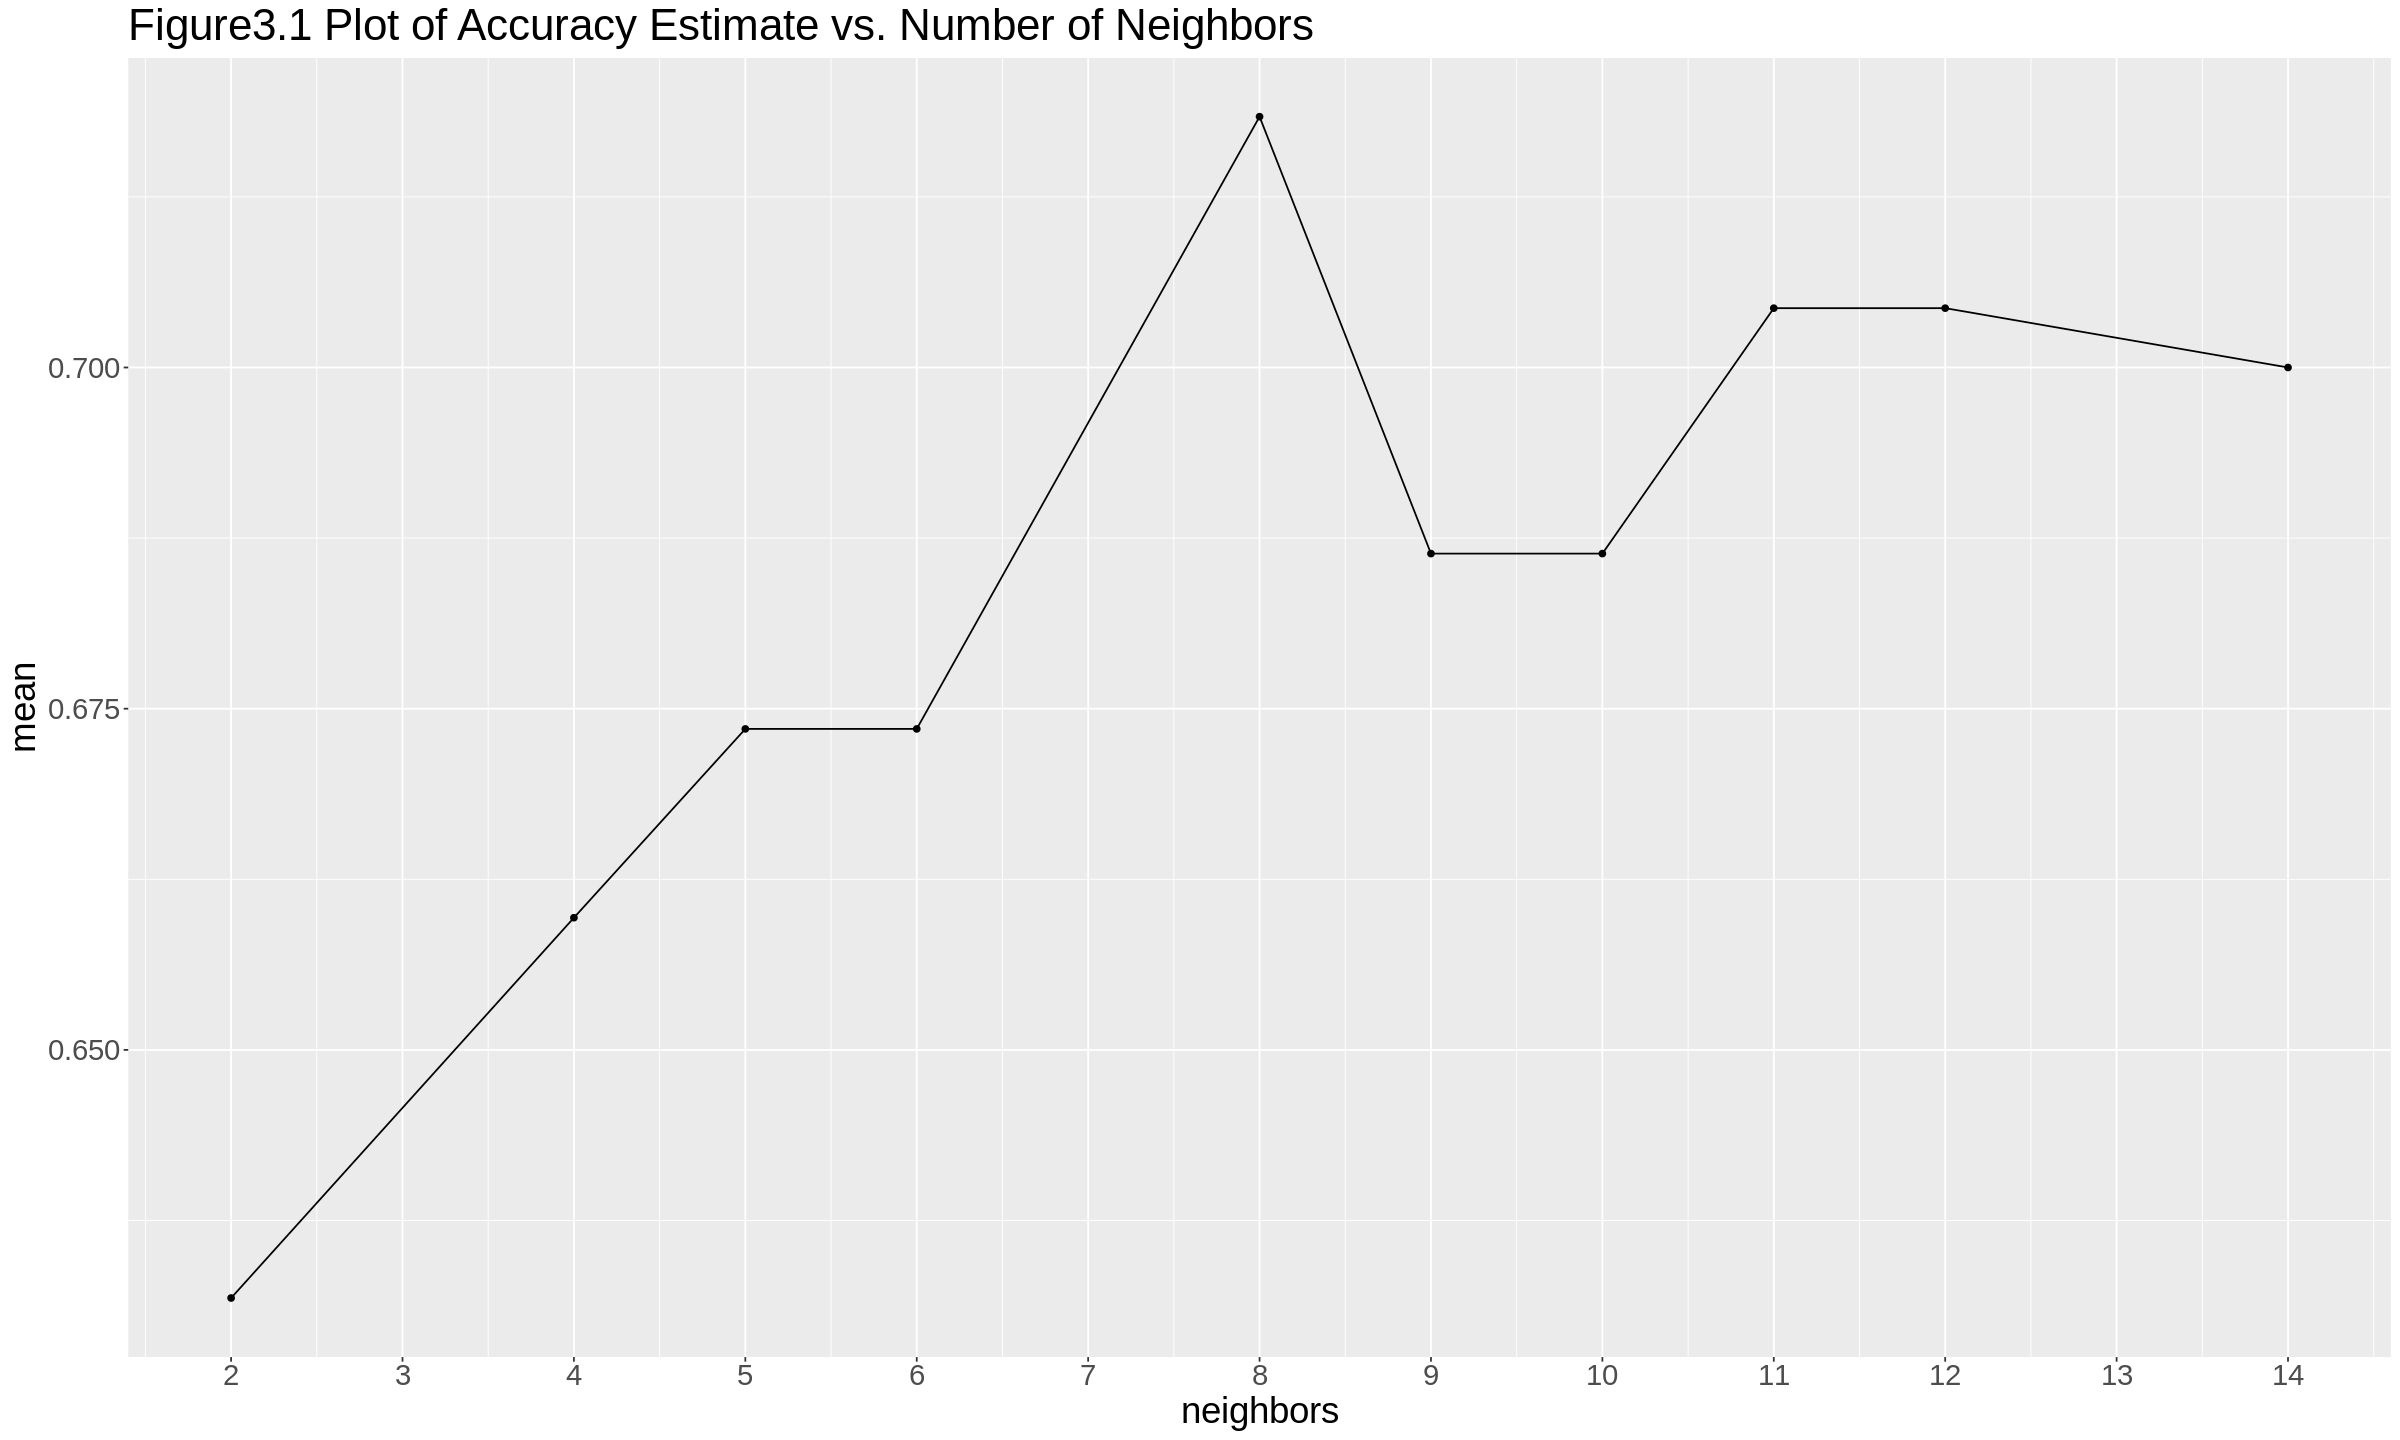

In [70]:
set.seed(2022)
options(repr.plot.height = 12, repr.plot.width = 20)

vrecipe <- recipe(num ~ age + thalach+oldpeak, data = cleveland_training) %>%
           step_scale(all_numeric()) %>%
           step_center(all_numeric())

vfold <- vfold_cv(cleveland_training, v = 10, strata = num)
         knn_tune = nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
         set_engine("kknn") %>%
         set_mode("classification")
  
knn_results <- workflow() %>%
               add_recipe(vrecipe) %>%
               add_model(knn_tune) %>%
               tune_grid(resamples = vfold, grid = 10) %>%
               collect_metrics()

accuracies <- knn_results %>% 
              filter(.metric == "accuracy")

cross_val_plot <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
                  geom_point() +
                  geom_line() +
                  ggtitle("Figure3.1 Plot of Accuracy Estimate vs. Number of Neighbors") +
                  scale_x_continuous(breaks = c(0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15))+
                  theme(text = element_text(size = 22))

cross_val_plot 


<blockquote>As we can see from figure 3.1, knn = 7 and 11 have higher accuracy than any other knn value. However, their value of accuracy are pretty close to each other, making it hard to tell which is higher. To pick the best knn value, we use the arrange and slice function to directly select our K value that has the highest accuracy.

In [76]:
#Determining the best value for knn-neighbor 
best_neightbor <- accuracies %>%
                  arrange(neighbors) %>%
                  select(mean, neighbors) %>%
                  arrange(desc(mean)) %>%
                  slice(1)
best_neightbor

mean,neighbors
<dbl>,<int>
0.7183794,8


Table3.1 Number of knn-neighbors with the highest accuracy

After training our classifier, we use it to predict the testing dataset by performing the following steps:

1. We perform the recipe and knn_model steps again and put it in the workflow, assigning it to an object called mnist_fit.
2. In order to show the accuracy of our classifier, we perform a prediction on our testing dataset by passing the mnist_fit and the testing dataset to the predict function. A testing column is bound to the data output. A prediction column is then binded to the testing data set in mnist_predictions.
3. We use the metric function to show the accuracy of our classifier.



In [72]:
set.seed(2022)

cleveland_recipe <- recipe(num ~ age + thalach+oldpeak, data = cleveland_training) %>%
                    step_scale(all_predictors()) %>%
                    step_center(all_predictors())

mnist_spec <- nearest_neighbor(weight_func = "rectangular", neighbors =8) %>%
              set_engine("kknn") %>%
              set_mode("classification")

mnist_fit <- workflow() %>%
             add_recipe(cleveland_recipe) %>%
             add_model(mnist_spec) %>%
             fit(data = cleveland_training)

mnist_predictions <- predict(mnist_fit, cleveland_testing) %>%
                     bind_cols(cleveland_testing)

mnist_metrics <- mnist_predictions %>%
                 metrics(truth = num, estimate = .pred_class) %>%
                filter(.metric == "accuracy")
mnist_metrics

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.8243243


Table3.2 The accuracy of our classifier is 82.4%.

We then plot the confusion Matrix(Table3.3).

In [74]:
confusion <- mnist_predictions %>% 
             conf_mat(truth = num, estimate = .pred_class)
confusion

          Truth
Prediction  0  1
         0 35  8
         1  5 26

Table3.3 Confusion Matrix of Our Model

As shown, a total of 61 observations are correctly predicted, and 13 are not. 5 of them being false positive, and 8 of them being false negative.

False positive means that people without heart disease are predicted by the classifier as with heart disease, and false negative means people with heart disease are predicted by the classifier as without heart disease.  

# Discussion

### What we found



First of all, we found that age and maximum heart rate(thalach) to be the best predictors.

After the training and testing, we found our classifier to be 71.6% accurate. 

We also found a positive relationship between age and the presence of heart disease, and a negative relationship between maximum heart rate and heart disease. 



### Whether the findings are expected

In general, this is roughly what we expected to find. 

For the accuracy of our classifier, it is not extremely accurate, but significantly more accurate than purely guessing. This is expected because there is a clear but not an extremely strong relationship between our predictors and class for predicting.

We concluded from the study that an increase in age is linked with increase in possibility of heart disease. This is supported by our reference: as people get older, their cardiovascular system begin to experience problems like high blood pressure and clotting, all of which lead to cardiovascular problems (Razvi, 2008).

We also learnt that a decrease in heart rate is linked with increase in possibility of heart disease. This is also supported by our reference: in people with heart disease, “low-frequency control mechanism” is dominant, meaning that the heart would have a lower heart rate (Huikuri, 2001).


### Impact of the above findings

From the data analysis we performed above, we can see that the correlation between age plus maximum heart rate and whether a person has heart disease is relatively high. From here, we can then implement this finding into public health guidelines and suggest that elders with a high maximum heart rate should look out for heart problems. For example, when elders visit their family doctors or get an ECG check, if their max heart rate is high, then the health practitioners can suggest them to take further heart examinations, finding possible heart problems at an earlier point and reducing the risk of developing more severe heart disease.


### Future questions that our study leads to

* What is the relationship between heart disease and resting heart rate? Our study focused on maximum heart rate, but resting heart rate may also have a relationship with heart disease.
* Is there any relationship between age and maximum heart rate? 
* What exercises or daily practices can increase thalach, especially for elders? To what extent should health practitioners inform people about their higher risk of getting heart disease based on our findings, given that the accuracy of our model is not ideal?


# Reference 

#### Bibliography

World Health Organization. (n.d.). Who reveals leading causes of Death and Disability Worldwide: 2000-2019. World Health Organization. Retrieved April 8, 2022, from https://www.who.int/news/item/09-12-2020-who-reveals-leading-causes-of-death-and-disability-worldwide-2000-2019 
Huikuri, H. V., & Mäkikallio, T. H. (2001, June 12). Heart rate variability in ischemic heart disease. Autonomic Neuroscience. Retrieved April 7, 2022, from https://www.sciencedirect.com/science/article/pii/S1566070201002739 
Razvi, S. (2008, August 1). The Influence of Age on the Relationship between Subclinical Hypothyroidism and Ischemic Heart Disease: A Metaanalysis. Academic.oup.com. Retrieved April 9, 2022, from https://academic.oup.com/jcem/article/93/8/2998/2598481?login=false


#### Data Source
W. Aha, D., 2022. UCI Machine Learning Repository: Heart Disease Data Set.
[online] Archive.ics.uci.edu. Available at: https://archive.ics.uci.edu/ml/datasets/Heart+Disease [Accessed 6 April 2022].


# Thank you for watching!